In [4]:
!pip install -q wandb


In [5]:
import wandb
wandb.login(key='66e08c83e7351f9e1b1030e876e1e37674030b28')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mayankshivhare45 (mayank17). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import torchmetrics # Use torchmetrics for mIoU
from torchmetrics.segmentation import MeanIoU

# --- Configuration ---
config = {
    "dataset_path": "/kaggle/input/seg-data/dataset_224", # IMPORTANT: Change this path
    "num_classes": 13,
    "batch_size": 8, # Adjust based on your GPU memory
    "epochs": 30,      # Increase for better convergence
    "learning_rate": 1e-4,
    "backbone": "vgg19", # or "vgg19"
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "wandb_project": "FCN_Semantic_Segmentation",
    "seed": 45,
    "img_size": (224, 224)
}

# --- Reproducibility ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config["seed"])

# --- Class Names and Color Map ---
CLASS_NAMES = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]

# Create a color map for visualization (13 distinct colors)
# Using tab20 colormap and extending it slightly
cmap = plt.get_cmap('tab20', config["num_classes"])
COLOR_MAP = [cmap(i)[:3] for i in range(config["num_classes"])]
COLOR_MAP_UINT8 = [(int(r*255), int(g*255), int(b*255)) for r, g, b in COLOR_MAP]

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        # Filter out potential hidden files like .DS_Store
        self.image_filenames = sorted([f for f in os.listdir(self.image_dir) if not f.startswith('.')])
        self.label_filenames = sorted([f for f in os.listdir(self.label_dir) if not f.startswith('.')])
        self.transform = transform
        self.target_transform = target_transform # Keep target_transform if provided

        # Ensure images and labels match
        assert len(self.image_filenames) == len(self.label_filenames), \
            f"Mismatch in number of images ({len(self.image_filenames)}) and labels ({len(self.label_filenames)}) in {root_dir}"
        for img_fn, lbl_fn in zip(self.image_filenames, self.label_filenames):
             # Check if base names match (e.g., 'img1.png', 'img1.png')
             # Or if label has different extension (e.g., 'img1.jpg', 'img1.png')
             img_base = os.path.splitext(img_fn)[0]
             lbl_base = os.path.splitext(lbl_fn)[0]
             assert img_base == lbl_base, \
                 f"Mismatch filenames (bases): {img_base} (from {img_fn}) and {lbl_base} (from {lbl_fn})"


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        try:
            image = Image.open(img_path).convert('RGB')
            # Load label as grayscale, assuming it contains integer class IDs 0-12
            label_pil = Image.open(label_path).convert('L')
        except Exception as e:
            print(f"Error loading index {idx}: {self.image_filenames[idx]}, {self.label_filenames[idx]}")
            print(e)
            raise IOError(f"Could not load image/label at index {idx}")


        # Apply image transform (ToTensor, Normalize etc.)
        if self.transform:
            image = self.transform(image)

        # Apply label transform (Resize only)
        if self.target_transform:
            label_pil_resized = self.target_transform(label_pil)
        else:
             label_pil_resized = label_pil # No resize if no transform provided


        # --- Convert resized PIL label to LongTensor ---
        # Convert PIL image to numpy array first
        label_np = np.array(label_pil_resized, dtype=np.int64)
        # Convert numpy array to tensor
        label = torch.from_numpy(label_np).long()
        # Label should now be a [H, W] tensor with integer class IDs

        # Clamp label values to be within num_classes range just in case
        # Values outside this range will cause errors in CrossEntropyLoss
        label = torch.clamp(label, 0, config["num_classes"] - 1)

        # Print unique values for debugging the first few samples
        # if idx < 5:
        #    print(f"Sample {idx}: Unique label values after processing: {torch.unique(label)}")

        return image, label
# --- Transformations ---
# Image transforms: Resize, ToTensor, Normalize
img_transform = transforms.Compose([
    transforms.Resize(config["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Label transforms: Resize (using nearest neighbor), ToTensor
# Note: We convert to LongTensor within the dataset __getitem__ for CrossEntropy
__
label_transform = transforms.Compose([
    transforms.Resize(config["img_size"], interpolation=transforms.InterpolationMode.NEAREST),
])


# --- Dataset Visualization (Task 2.1) ---
# --- Dataset Visualization (Task 2.1) ---
def visualize_dataset_sample(dataset, index=0):
    """Visualizes a sample image and its class-specific masks."""
    image, label_tensor = dataset[index] # Get raw tensor label

    # Denormalize image for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image_display = inv_normalize(image).permute(1, 2, 0).cpu().numpy()
    image_display = np.clip(image_display, 0, 1)

    label_numpy = label_tensor.cpu().numpy() # Label might be [1, H, W] or [H, W]

    # --- FIX: Ensure label_numpy is 2D ---
    if label_numpy.ndim == 3 and label_numpy.shape[0] == 1:
        # print(f"DEBUG: Squeezing label_numpy shape from {label_numpy.shape}")
        label_numpy = label_numpy.squeeze(0) # Remove leading dimension if present
    elif label_numpy.ndim != 2:
         # If it's not 3D with size 1 first, and not 2D, it's an unexpected shape
         raise ValueError(f"Unexpected label shape received in visualize_dataset_sample: {label_numpy.shape}")
    # Now label_numpy is guaranteed to be (H, W)

    num_classes = config["num_classes"]
    rows = 3
    # Calculate columns needed (+2 for original image and combined mask)
    cols = (num_classes + 2 + rows - 1) // rows


    plt.figure(figsize=(18, 9)) # Adjust figsize if needed

    # Plot original image
    plt.subplot(rows, cols, 1)
    plt.imshow(image_display)
    plt.title("Original Image")
    plt.axis('off')

    # Plot original mask (colored)
    # This uses the now corrected 2D label_numpy
    colored_mask = np.zeros((*label_numpy.shape, 3), dtype=np.uint8) # Shape is (H, W, 3)
    for i in range(num_classes):
         mask = label_numpy == i # mask is (H, W) boolean
         colored_mask[mask] = COLOR_MAP_UINT8[i]
    plt.subplot(rows, cols, 2)
    plt.imshow(colored_mask) # This should now work
    plt.title("Ground Truth Mask")
    plt.axis('off')


    # Plot binary masks for each class
    for i in range(num_classes):
        binary_mask = (label_numpy == i).astype(np.uint8) * 255
        # Calculate subplot index starting from 3
        plot_index = i + 3
        if plot_index <= rows * cols: # Check if subplot index is valid
             plt.subplot(rows, cols, plot_index)
             plt.imshow(binary_mask, cmap='gray')
             plt.title(f"{CLASS_NAMES[i]} (ID: {i})", fontsize=8) # Smaller font if needed
             plt.axis('off')
        else:
            print(f"Warning: Not enough subplots calculated ({rows}x{cols}) to display class {i+1}/{num_classes}")


    plt.tight_layout()
    plt.show()


# --- FCN Model Definition ---
def get_vgg_backbone(name="vgg16", pretrained=True):
    """Loads a pretrained VGG backbone"""
    if name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
    elif name == "vgg19":
         model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1 if pretrained else None)
    else:
        raise ValueError(f"Unsupported backbone: {name}")

    # Remove the classifier part
    features = model.features
    # Identify pool3, pool4 layers based on VGG structure
    # VGG16: pool3 is layer 16, pool4 is layer 23, pool5 is layer 30
    # VGG19: pool3 is layer 18, pool4 is layer 27, pool5 is layer 36
    # Use names if available, otherwise indices (check print(model.features))
    pool_indices = {'vgg16': {'pool3': 16, 'pool4': 23, 'pool5': 30},
                    'vgg19': {'pool3': 18, 'pool4': 27, 'pool5': 36}}
    return features, pool_indices[name]


class FCN(nn.Module):
    def __init__(self, backbone_name, num_classes, variant='FCN-32s', pretrained=True, freeze_backbone=False):
        super().__init__()
        self.variant = variant
        self.num_classes = num_classes

        self.features, self.pool_indices = get_vgg_backbone(backbone_name, pretrained)

        # Freeze backbone if requested
        if freeze_backbone:
            print("Freezing backbone weights.")
            for param in self.features.parameters():
                param.requires_grad = False

        # Determine feature map depth after pool5
        # Run a dummy tensor to find out the number of channels
        with torch.no_grad():
             dummy_input = torch.zeros(1, 3, config["img_size"][0], config["img_size"][1])
             pool5_out_channels = self.features(dummy_input).shape[1]
             # Also get pool4 and pool3 channels if needed
             pool4_idx = self.pool_indices['pool4']
             pool3_idx = self.pool_indices['pool3']
             pool4_out_channels = self.features[:pool4_idx+1](dummy_input).shape[1]
             pool3_out_channels = self.features[:pool3_idx+1](dummy_input).shape[1]


        # Replace VGG classifier with 1x1 convolutions
        self.score_pool5 = nn.Conv2d(pool5_out_channels, num_classes, kernel_size=1)

        if variant == 'FCN-32s':
            # Upsample directly to input size
            # Kernel size should be 2 * stride, padding = stride / 2 for bilinear like init
            self.upsample32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)
            self._initialize_weights(self.upsample32) # Initialize upsampling weights bilinearly

        elif variant == 'FCN-16s':
            self.score_pool4 = nn.Conv2d(pool4_out_channels, num_classes, kernel_size=1)
            self.upsample2_pool5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
            self.upsample16_combined = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)
            self._initialize_weights(self.upsample2_pool5, self.upsample16_combined)

        elif variant == 'FCN-8s':
             self.score_pool4 = nn.Conv2d(pool4_out_channels, num_classes, kernel_size=1)
             self.score_pool3 = nn.Conv2d(pool3_out_channels, num_classes, kernel_size=1)

             self.upsample2_pool5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
             self.upsample2_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
             self.upsample8_combined = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
             self._initialize_weights(self.upsample2_pool5, self.upsample2_pool4, self.upsample8_combined)

        else:
            raise ValueError(f"Unknown FCN variant: {variant}")

    def _initialize_weights(self, *layers):
        """Initialize ConvTranspose2d layers for bilinear upsampling."""
        for layer in layers:
            if isinstance(layer, nn.ConvTranspose2d):
                # Bilinear initialization
                # From: https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
                factor = (layer.kernel_size[0] + 1) // 2
                if layer.kernel_size[0] % 2 == 1:
                    center = factor - 1
                else:
                    center = factor - 0.5
                og = np.ogrid[:layer.kernel_size[0], :layer.kernel_size[1]]
                filt = (1 - abs(og[0] - center) / factor) * \
                       (1 - abs(og[1] - center) / factor)
                weight = np.zeros((layer.in_channels, layer.out_channels,
                                   layer.kernel_size[0], layer.kernel_size[1]),
                                  dtype=np.float32)
                weight[range(layer.in_channels), range(layer.out_channels), :, :] = filt
                layer.weight.data.copy_(torch.from_numpy(weight))
                if layer.bias is not None:
                     nn.init.constant_(layer.bias.data, 0)

        # Initialize score layers with zeros (as suggested in paper)
        if hasattr(self, 'score_pool5'): nn.init.zeros_(self.score_pool5.weight) ; nn.init.zeros_(self.score_pool5.bias)
        if hasattr(self, 'score_pool4'): nn.init.zeros_(self.score_pool4.weight) ; nn.init.zeros_(self.score_pool4.bias)
        if hasattr(self, 'score_pool3'): nn.init.zeros_(self.score_pool3.weight) ; nn.init.zeros_(self.score_pool3.bias)


    def forward(self, x):
        input_size = x.shape[-2:] # H, W
        pool3_idx = self.pool_indices['pool3']
        pool4_idx = self.pool_indices['pool4']
        pool5_idx = self.pool_indices['pool5'] # End of features usually

        # Pass through backbone, saving intermediate features if needed
        pool3_feat, pool4_feat, pool5_feat = None, None, None
        current_feat = x
        for i, layer in enumerate(self.features):
            current_feat = layer(current_feat)
            if i == pool3_idx and self.variant in ['FCN-8s']:
                pool3_feat = current_feat
            elif i == pool4_idx and self.variant in ['FCN-16s', 'FCN-8s']:
                pool4_feat = current_feat
            elif i == pool5_idx: # Assumes pool5 is the last layer of features
                pool5_feat = current_feat
                if self.variant == 'FCN-32s': # Stop early if we only need pool5
                     break

        # --- Score and Upsample ---
        score5 = self.score_pool5(pool5_feat)

        if self.variant == 'FCN-32s':
            out = self.upsample32(score5)
            # Crop to input size (ConvTranspose2d might add padding)
            out = self._crop(out, input_size)
            return out

        elif self.variant == 'FCN-16s':
            score4 = self.score_pool4(pool4_feat)
            upsampled_score5 = self.upsample2_pool5(score5)

            # Crop score4 to match upsampled_score5 size
            score4_cropped = self._crop(score4, upsampled_score5.shape[-2:])
            combined16 = score4_cropped + upsampled_score5

            out = self.upsample16_combined(combined16)
            out = self._crop(out, input_size)
            return out

        elif self.variant == 'FCN-8s':
             score4 = self.score_pool4(pool4_feat)
             score3 = self.score_pool3(pool3_feat)

             upsampled_score5 = self.upsample2_pool5(score5)
             score4_cropped = self._crop(score4, upsampled_score5.shape[-2:])
             combined_pool45 = score4_cropped + upsampled_score5

             upsampled_pool45 = self.upsample2_pool4(combined_pool45)
             score3_cropped = self._crop(score3, upsampled_pool45.shape[-2:])
             combined_pool345 = score3_cropped + upsampled_pool45

             out = self.upsample8_combined(combined_pool345)
             out = self._crop(out, input_size)
             return out

    def _crop(self, tensor, target_size):
        """Center crop a tensor to target size (H, W)."""
        _, _, H, W = tensor.shape
        th, tw = target_size
        if H == th and W == tw:
            return tensor
        # Calculate crop start indices
        h_start = (H - th) // 2
        w_start = (W - tw) // 2
        return tensor[:, :, h_start:h_start+th, w_start:w_start+tw]


# --- Training and Validation Functions ---
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, variant, freeze_status):
    model.train()
    total_loss = 0.0
    num_batches = len(dataloader)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} Train ({variant}, {freeze_status})")
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device).long() # Ensure masks are Long

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
        wandb.log({f"Train/Batch Loss ({variant}, {freeze_status})": loss.item()})


    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1} Train Loss ({variant}, {freeze_status}): {avg_loss:.4f}")
    return avg_loss

def validate(model, dataloader, criterion, metric, device, epoch, variant, freeze_status):
    model.eval()
    total_loss = 0.0
    num_batches = len(dataloader)
    metric.reset()

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} Val ({variant}, {freeze_status})")
    with torch.no_grad():
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            # print(f"Preds shape: {preds.shape}, Masks shape: {masks.shape}")
            metric.update(preds, masks) # Metric on CPU

            pbar.set_postfix(loss=loss.item())


    avg_loss = total_loss / num_batches
    final_miou = metric.compute()
    print(f"Epoch {epoch+1} Val Loss ({variant}, {freeze_status}): {avg_loss:.4f}, mIoU: {final_miou}")
    return avg_loss, final_miou


# --- Evaluation on Test Set ---
def evaluate_test_set(model, dataloader, metric, device, variant, freeze_status):
    model.eval()
    metric.reset()
    pbar = tqdm(dataloader, desc=f"Evaluating Test Set ({variant}, {freeze_status})")

    with torch.no_grad():
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            # print(f"Preds shape: {preds.shape}, Masks shape: {masks.shape}")
            metric.update(preds, masks) # Metric on CPU

    final_miou = metric.compute()
    print(f"Test mIoU ({variant}, {freeze_status}): {final_miou}")
    return final_miou

# --- Visualization of Predictions ---
def visualize_predictions(model, dataloader, device, num_samples=5, variant=None, freeze_status=None):
    model.eval()
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    samples_shown = 0
    with torch.no_grad():
        for images, masks_gt in dataloader:
            if samples_shown >= num_samples:
                break

            images, masks_gt = images.to(device), masks_gt.to(device).long()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    break

                img_display = inv_normalize(images[i]).permute(1, 2, 0).cpu().numpy()
                img_display = np.clip(img_display, 0, 1)

                gt_mask_numpy = masks_gt[i].cpu().numpy()
                pred_mask_numpy = preds[i].cpu().numpy()

                # Colorize masks
                gt_colored = np.zeros((*gt_mask_numpy.shape, 3), dtype=np.uint8)
                pred_colored = np.zeros((*pred_mask_numpy.shape, 3), dtype=np.uint8)
                for c_id in range(config["num_classes"]):
                    gt_colored[gt_mask_numpy == c_id] = COLOR_MAP_UINT8[c_id]
                    pred_colored[pred_mask_numpy == c_id] = COLOR_MAP_UINT8[c_id]

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img_display)
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(gt_colored)
                plt.title("Ground Truth Mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_colored)
                plt.title(f"Predicted Mask ({variant}, {freeze_status})")
                plt.axis('off')

                plt.suptitle(f"Sample {samples_shown + 1}")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
                # Save or show plot
                save_filename = f"prediction_{variant}_{freeze_status}_sample_{samples_shown+1}.png"
                plt.savefig(save_filename)
                print(f"Saved prediction visualization: {save_filename}")
                # plt.show() # Comment out if running non-interactively
                plt.close()


                samples_shown += 1




Using device: cuda
Splitting the original training data (2000 samples) into:
  - Training set: 1600 samples
  - Validation set: 400 samples
DataLoaders created: Train (1600 samples), Val (400 samples), Test (500 samples)

Visualizing one dataset sample and its class masks (from original training set)...


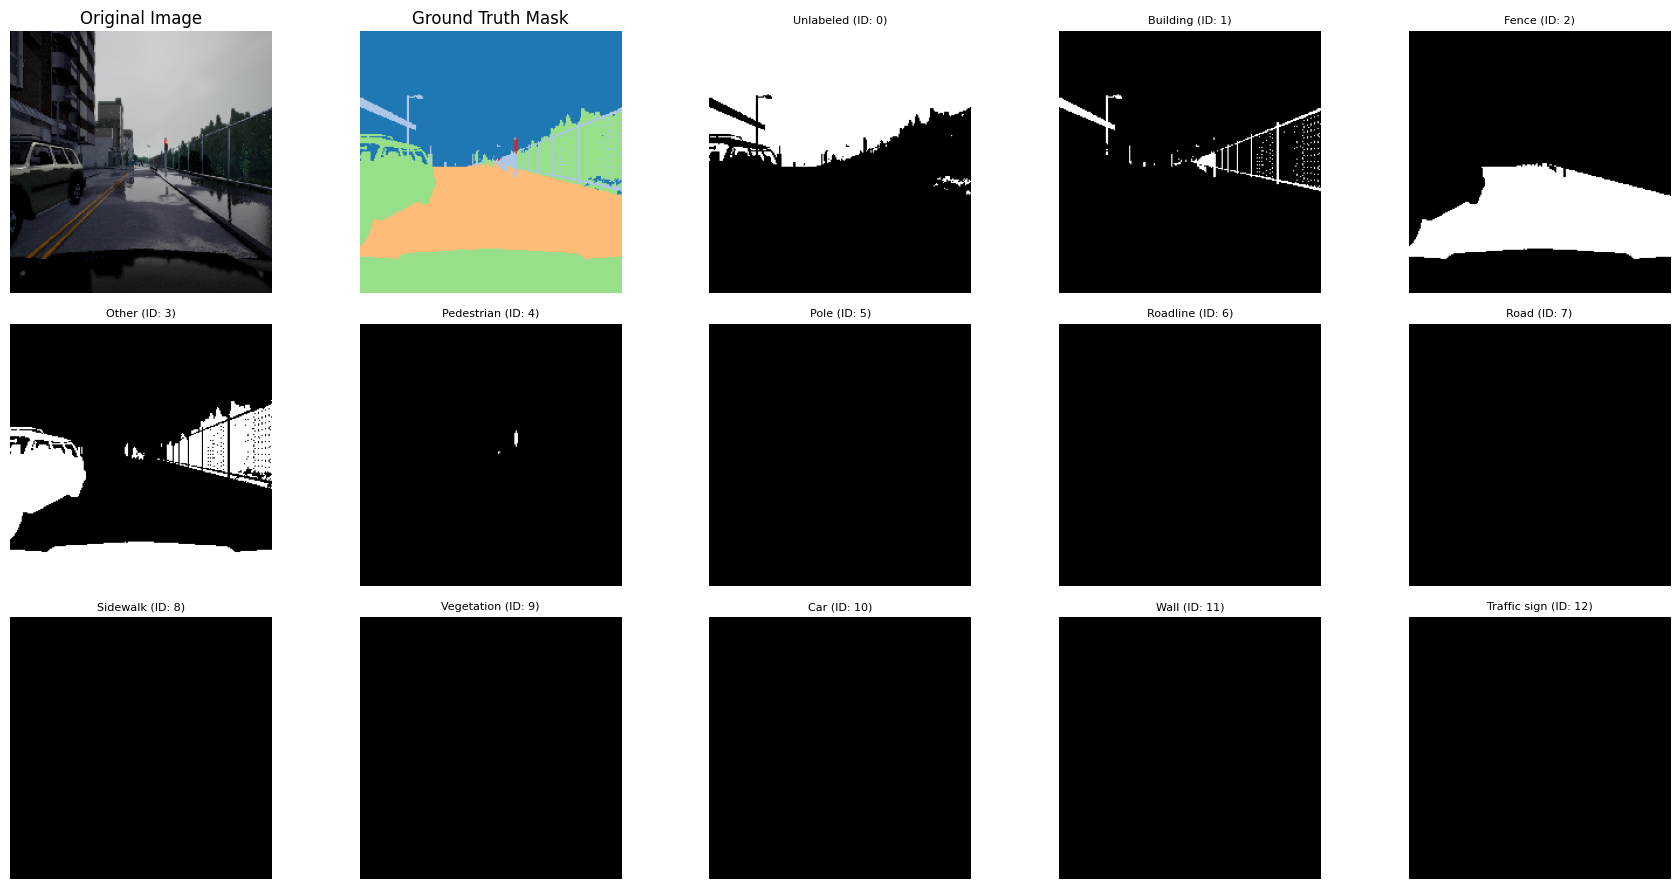


--- Training FCN-32s with Frozen Backbone ---


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 224MB/s] 


Freezing backbone weights.


Epoch 1 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:18<00:00, 10.57it/s, loss=0.863]


Epoch 1 Train Loss (FCN-32s, Frozen): 1.5029


Epoch 1 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.67it/s, loss=0.853]


Epoch 1 Val Loss (FCN-32s, Frozen): 0.9272, mIoU: 0.15164656937122345
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1516)


Epoch 2 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.61it/s, loss=0.615]


Epoch 2 Train Loss (FCN-32s, Frozen): 0.7230


Epoch 2 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.54it/s, loss=0.55] 


Epoch 2 Val Loss (FCN-32s, Frozen): 0.6087, mIoU: 0.16511011123657227
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1651)


Epoch 3 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.44it/s, loss=0.5]  


Epoch 3 Train Loss (FCN-32s, Frozen): 0.5334


Epoch 3 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.36it/s, loss=0.453]


Epoch 3 Val Loss (FCN-32s, Frozen): 0.5014, mIoU: 0.17177118360996246
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1718)


Epoch 4 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.25it/s, loss=0.407]


Epoch 4 Train Loss (FCN-32s, Frozen): 0.4598


Epoch 4 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.12it/s, loss=0.41] 


Epoch 4 Val Loss (FCN-32s, Frozen): 0.4520, mIoU: 0.17518264055252075
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1752)


Epoch 5 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:18<00:00, 11.06it/s, loss=0.388]


Epoch 5 Train Loss (FCN-32s, Frozen): 0.4222


Epoch 5 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, loss=0.388]


Epoch 5 Val Loss (FCN-32s, Frozen): 0.4235, mIoU: 0.17707513272762299
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1771)


Epoch 6 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:18<00:00, 10.91it/s, loss=0.44] 


Epoch 6 Train Loss (FCN-32s, Frozen): 0.3989


Epoch 6 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.90it/s, loss=0.376]


Epoch 6 Val Loss (FCN-32s, Frozen): 0.4044, mIoU: 0.17858217656612396
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1786)


Epoch 7 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:18<00:00, 10.76it/s, loss=0.412]


Epoch 7 Train Loss (FCN-32s, Frozen): 0.3826


Epoch 7 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.71it/s, loss=0.366]


Epoch 7 Val Loss (FCN-32s, Frozen): 0.3909, mIoU: 0.17989180982112885
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1799)


Epoch 8 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:18<00:00, 10.60it/s, loss=0.295]


Epoch 8 Train Loss (FCN-32s, Frozen): 0.3707


Epoch 8 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.55it/s, loss=0.36] 


Epoch 8 Val Loss (FCN-32s, Frozen): 0.3809, mIoU: 0.18067392706871033
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1807)


Epoch 9 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.43it/s, loss=0.374]


Epoch 9 Train Loss (FCN-32s, Frozen): 0.3615


Epoch 9 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.35it/s, loss=0.354]


Epoch 9 Val Loss (FCN-32s, Frozen): 0.3730, mIoU: 0.1814464032649994
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1814)


Epoch 10 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.33it/s, loss=0.344]


Epoch 10 Train Loss (FCN-32s, Frozen): 0.3543


Epoch 10 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.24it/s, loss=0.35] 


Epoch 10 Val Loss (FCN-32s, Frozen): 0.3668, mIoU: 0.18219497799873352
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1822)


Epoch 11 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.22it/s, loss=0.316]


Epoch 11 Train Loss (FCN-32s, Frozen): 0.3483


Epoch 11 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.18it/s, loss=0.347]


Epoch 11 Val Loss (FCN-32s, Frozen): 0.3616, mIoU: 0.18309994041919708
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1831)


Epoch 12 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.11it/s, loss=0.327]


Epoch 12 Train Loss (FCN-32s, Frozen): 0.3432


Epoch 12 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.10it/s, loss=0.342]


Epoch 12 Val Loss (FCN-32s, Frozen): 0.3569, mIoU: 0.18350417912006378
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1835)


Epoch 13 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.04it/s, loss=0.342]


Epoch 13 Train Loss (FCN-32s, Frozen): 0.3389


Epoch 13 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.08it/s, loss=0.338]


Epoch 13 Val Loss (FCN-32s, Frozen): 0.3530, mIoU: 0.1838531494140625
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1839)


Epoch 14 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.09it/s, loss=0.314]


Epoch 14 Train Loss (FCN-32s, Frozen): 0.3350


Epoch 14 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.10it/s, loss=0.337]


Epoch 14 Val Loss (FCN-32s, Frozen): 0.3495, mIoU: 0.1847798377275467
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1848)


Epoch 15 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:19<00:00, 10.03it/s, loss=0.299]


Epoch 15 Train Loss (FCN-32s, Frozen): 0.3315


Epoch 15 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.98it/s, loss=0.333]


Epoch 15 Val Loss (FCN-32s, Frozen): 0.3466, mIoU: 0.18539848923683167
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1854)


Epoch 16 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.95it/s, loss=0.321]


Epoch 16 Train Loss (FCN-32s, Frozen): 0.3285


Epoch 16 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.97it/s, loss=0.33] 


Epoch 16 Val Loss (FCN-32s, Frozen): 0.3435, mIoU: 0.18600627779960632
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1860)


Epoch 17 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.92it/s, loss=0.27] 


Epoch 17 Train Loss (FCN-32s, Frozen): 0.3257


Epoch 17 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.96it/s, loss=0.329]


Epoch 17 Val Loss (FCN-32s, Frozen): 0.3411, mIoU: 0.1864246129989624
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1864)


Epoch 18 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.87it/s, loss=0.328]


Epoch 18 Train Loss (FCN-32s, Frozen): 0.3231


Epoch 18 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.94it/s, loss=0.326]


Epoch 18 Val Loss (FCN-32s, Frozen): 0.3387, mIoU: 0.1871974915266037
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1872)


Epoch 19 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.89it/s, loss=0.347]


Epoch 19 Train Loss (FCN-32s, Frozen): 0.3208


Epoch 19 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.96it/s, loss=0.324]


Epoch 19 Val Loss (FCN-32s, Frozen): 0.3366, mIoU: 0.18764984607696533
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1876)


Epoch 20 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.98it/s, loss=0.295]


Epoch 20 Train Loss (FCN-32s, Frozen): 0.3186


Epoch 20 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.91it/s, loss=0.322]


Epoch 20 Val Loss (FCN-32s, Frozen): 0.3344, mIoU: 0.18797917664051056
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1880)


Epoch 21 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.77it/s, loss=0.264]


Epoch 21 Train Loss (FCN-32s, Frozen): 0.3166


Epoch 21 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.76it/s, loss=0.32] 


Epoch 21 Val Loss (FCN-32s, Frozen): 0.3326, mIoU: 0.18826813995838165
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1883)


Epoch 22 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.77it/s, loss=0.36] 


Epoch 22 Train Loss (FCN-32s, Frozen): 0.3147


Epoch 22 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.75it/s, loss=0.318]


Epoch 22 Val Loss (FCN-32s, Frozen): 0.3310, mIoU: 0.18845973908901215
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1885)


Epoch 23 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.77it/s, loss=0.303]


Epoch 23 Train Loss (FCN-32s, Frozen): 0.3130


Epoch 23 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.88it/s, loss=0.317]


Epoch 23 Val Loss (FCN-32s, Frozen): 0.3294, mIoU: 0.18879514932632446
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1888)


Epoch 24 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.81it/s, loss=0.295]


Epoch 24 Train Loss (FCN-32s, Frozen): 0.3114


Epoch 24 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.91it/s, loss=0.315]


Epoch 24 Val Loss (FCN-32s, Frozen): 0.3279, mIoU: 0.18904048204421997
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1890)


Epoch 25 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.78it/s, loss=0.279]


Epoch 25 Train Loss (FCN-32s, Frozen): 0.3099


Epoch 25 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.78it/s, loss=0.314]


Epoch 25 Val Loss (FCN-32s, Frozen): 0.3265, mIoU: 0.18909196555614471
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1891)


Epoch 26 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.77it/s, loss=0.344]


Epoch 26 Train Loss (FCN-32s, Frozen): 0.3085


Epoch 26 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.72it/s, loss=0.313]


Epoch 26 Val Loss (FCN-32s, Frozen): 0.3255, mIoU: 0.18934766948223114
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1893)


Epoch 27 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.77it/s, loss=0.332]


Epoch 27 Train Loss (FCN-32s, Frozen): 0.3071


Epoch 27 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.75it/s, loss=0.311]


Epoch 27 Val Loss (FCN-32s, Frozen): 0.3241, mIoU: 0.19026532769203186
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1903)


Epoch 28 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.77it/s, loss=0.356]


Epoch 28 Train Loss (FCN-32s, Frozen): 0.3059


Epoch 28 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.87it/s, loss=0.311]


Epoch 28 Val Loss (FCN-32s, Frozen): 0.3230, mIoU: 0.18968519568443298


Epoch 29 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.78it/s, loss=0.314]


Epoch 29 Train Loss (FCN-32s, Frozen): 0.3047


Epoch 29 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.94it/s, loss=0.31] 


Epoch 29 Val Loss (FCN-32s, Frozen): 0.3218, mIoU: 0.19100171327590942
Saved best model to best_model_FCN-32s_Frozen.pth (mIoU: 0.1910)


Epoch 30 Train (FCN-32s, Frozen): 100%|██████████| 200/200 [00:20<00:00,  9.81it/s, loss=0.317]


Epoch 30 Train Loss (FCN-32s, Frozen): 0.3036


Epoch 30 Val (FCN-32s, Frozen): 100%|██████████| 50/50 [00:05<00:00,  9.93it/s, loss=0.309]
<ipython-input-7-53bcdfbe03c6>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

Epoch 30 Val Loss (FCN-32s, Frozen): 0.3210, mIoU: 0.19056233763694763

--- Evaluating FCN-32s (Frozen) on Test Set ---


Evaluating Test Set (FCN-32s, Frozen): 100%|██████████| 63/63 [00:06<00:00,  9.80it/s]


Test mIoU (FCN-32s, Frozen): 0.1926977038383484

--- Visualizing Predictions for FCN-32s (Frozen) ---
Saved prediction visualization: prediction_FCN-32s_Frozen_sample_1.png
Saved prediction visualization: prediction_FCN-32s_Frozen_sample_2.png
Saved prediction visualization: prediction_FCN-32s_Frozen_sample_3.png
Saved prediction visualization: prediction_FCN-32s_Frozen_sample_4.png
Saved prediction visualization: prediction_FCN-32s_Frozen_sample_5.png


"Test/Final mIoU (FCN-32s, Frozen)",▁
"Train/Batch Loss (FCN-32s, Frozen)",█▆▆▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Train/Epoch Loss (FCN-32s, Frozen)",█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch Loss (FCN-32s, Frozen)",█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch mIoU (FCN-32s, Frozen)",▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
"Test/Final mIoU (FCN-32s, Frozen)",0.1927
"Train/Batch Loss (FCN-32s, Frozen)",0.31742
"Train/Epoch Loss (FCN-32s, Frozen)",0.3036
"Val/Epoch Loss (FCN-32s, Frozen)",0.32101
"Val/Epoch mIoU (FCN-32s, Frozen)",0.19056



--- Training FCN-16s with Frozen Backbone ---


Freezing backbone weights.


Epoch 1 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 11.94it/s, loss=0.463]


Epoch 1 Train Loss (FCN-16s, Frozen): 0.8498


Epoch 1 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.59it/s, loss=0.41] 


Epoch 1 Val Loss (FCN-16s, Frozen): 0.4413, mIoU: 0.18603520095348358
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.1860)


Epoch 2 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 11.79it/s, loss=0.312]


Epoch 2 Train Loss (FCN-16s, Frozen): 0.3691


Epoch 2 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.37it/s, loss=0.316]


Epoch 2 Val Loss (FCN-16s, Frozen): 0.3396, mIoU: 0.19303002953529358
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.1930)


Epoch 3 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.66it/s, loss=0.306]


Epoch 3 Train Loss (FCN-16s, Frozen): 0.3107


Epoch 3 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.34it/s, loss=0.287]


Epoch 3 Val Loss (FCN-16s, Frozen): 0.3069, mIoU: 0.19816352427005768
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.1982)


Epoch 4 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.57it/s, loss=0.232]


Epoch 4 Train Loss (FCN-16s, Frozen): 0.2874


Epoch 4 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.25it/s, loss=0.272]


Epoch 4 Val Loss (FCN-16s, Frozen): 0.2905, mIoU: 0.20124134421348572
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2012)


Epoch 5 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.48it/s, loss=0.214]


Epoch 5 Train Loss (FCN-16s, Frozen): 0.2740


Epoch 5 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.21it/s, loss=0.264]


Epoch 5 Val Loss (FCN-16s, Frozen): 0.2801, mIoU: 0.2026633471250534
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2027)


Epoch 6 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.45it/s, loss=0.327]


Epoch 6 Train Loss (FCN-16s, Frozen): 0.2649


Epoch 6 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.18it/s, loss=0.257]


Epoch 6 Val Loss (FCN-16s, Frozen): 0.2732, mIoU: 0.20332738757133484
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2033)


Epoch 7 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.46it/s, loss=0.222]


Epoch 7 Train Loss (FCN-16s, Frozen): 0.2584


Epoch 7 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.14it/s, loss=0.252]


Epoch 7 Val Loss (FCN-16s, Frozen): 0.2676, mIoU: 0.2054852545261383
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2055)


Epoch 8 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.45it/s, loss=0.256]


Epoch 8 Train Loss (FCN-16s, Frozen): 0.2532


Epoch 8 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.14it/s, loss=0.248]


Epoch 8 Val Loss (FCN-16s, Frozen): 0.2631, mIoU: 0.2059025764465332
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2059)


Epoch 9 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.48it/s, loss=0.214]


Epoch 9 Train Loss (FCN-16s, Frozen): 0.2491


Epoch 9 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.15it/s, loss=0.245]


Epoch 9 Val Loss (FCN-16s, Frozen): 0.2604, mIoU: 0.20558170974254608


Epoch 10 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.50it/s, loss=0.245]


Epoch 10 Train Loss (FCN-16s, Frozen): 0.2457


Epoch 10 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.16it/s, loss=0.241]


Epoch 10 Val Loss (FCN-16s, Frozen): 0.2565, mIoU: 0.20821994543075562
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2082)


Epoch 11 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.47it/s, loss=0.221]


Epoch 11 Train Loss (FCN-16s, Frozen): 0.2428


Epoch 11 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, loss=0.239]


Epoch 11 Val Loss (FCN-16s, Frozen): 0.2545, mIoU: 0.208542138338089
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2085)


Epoch 12 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.44it/s, loss=0.265]


Epoch 12 Train Loss (FCN-16s, Frozen): 0.2401


Epoch 12 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.16it/s, loss=0.236]


Epoch 12 Val Loss (FCN-16s, Frozen): 0.2520, mIoU: 0.20871838927268982
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2087)


Epoch 13 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.45it/s, loss=0.248]


Epoch 13 Train Loss (FCN-16s, Frozen): 0.2379


Epoch 13 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.15it/s, loss=0.234]


Epoch 13 Val Loss (FCN-16s, Frozen): 0.2500, mIoU: 0.20837129652500153


Epoch 14 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.46it/s, loss=0.229]


Epoch 14 Train Loss (FCN-16s, Frozen): 0.2359


Epoch 14 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.12it/s, loss=0.233]


Epoch 14 Val Loss (FCN-16s, Frozen): 0.2486, mIoU: 0.21018646657466888
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2102)


Epoch 15 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.45it/s, loss=0.209]


Epoch 15 Train Loss (FCN-16s, Frozen): 0.2341


Epoch 15 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.11it/s, loss=0.231]


Epoch 15 Val Loss (FCN-16s, Frozen): 0.2467, mIoU: 0.20943193137645721


Epoch 16 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.47it/s, loss=0.257]


Epoch 16 Train Loss (FCN-16s, Frozen): 0.2323


Epoch 16 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.13it/s, loss=0.23] 


Epoch 16 Val Loss (FCN-16s, Frozen): 0.2450, mIoU: 0.20937374234199524


Epoch 17 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.46it/s, loss=0.227]


Epoch 17 Train Loss (FCN-16s, Frozen): 0.2307


Epoch 17 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.09it/s, loss=0.229]


Epoch 17 Val Loss (FCN-16s, Frozen): 0.2436, mIoU: 0.21062521636486053
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2106)


Epoch 18 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.44it/s, loss=0.192]


Epoch 18 Train Loss (FCN-16s, Frozen): 0.2292


Epoch 18 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.06it/s, loss=0.228]


Epoch 18 Val Loss (FCN-16s, Frozen): 0.2420, mIoU: 0.2104913592338562


Epoch 19 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.42it/s, loss=0.221]


Epoch 19 Train Loss (FCN-16s, Frozen): 0.2277


Epoch 19 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, loss=0.225]


Epoch 19 Val Loss (FCN-16s, Frozen): 0.2406, mIoU: 0.2101617306470871


Epoch 20 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.45it/s, loss=0.189]


Epoch 20 Train Loss (FCN-16s, Frozen): 0.2263


Epoch 20 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.10it/s, loss=0.225]


Epoch 20 Val Loss (FCN-16s, Frozen): 0.2398, mIoU: 0.21061523258686066


Epoch 21 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.42it/s, loss=0.222]


Epoch 21 Train Loss (FCN-16s, Frozen): 0.2251


Epoch 21 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, loss=0.223]


Epoch 21 Val Loss (FCN-16s, Frozen): 0.2385, mIoU: 0.21131040155887604
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2113)


Epoch 22 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.44it/s, loss=0.197]


Epoch 22 Train Loss (FCN-16s, Frozen): 0.2238


Epoch 22 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.08it/s, loss=0.222]


Epoch 22 Val Loss (FCN-16s, Frozen): 0.2371, mIoU: 0.21042798459529877


Epoch 23 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.46it/s, loss=0.231]


Epoch 23 Train Loss (FCN-16s, Frozen): 0.2227


Epoch 23 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.07it/s, loss=0.223]


Epoch 23 Val Loss (FCN-16s, Frozen): 0.2364, mIoU: 0.21184417605400085
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2118)


Epoch 24 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.38it/s, loss=0.227]


Epoch 24 Train Loss (FCN-16s, Frozen): 0.2216


Epoch 24 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.95it/s, loss=0.22] 


Epoch 24 Val Loss (FCN-16s, Frozen): 0.2352, mIoU: 0.21124017238616943


Epoch 25 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.44it/s, loss=0.244]


Epoch 25 Train Loss (FCN-16s, Frozen): 0.2206


Epoch 25 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.09it/s, loss=0.219]


Epoch 25 Val Loss (FCN-16s, Frozen): 0.2344, mIoU: 0.21199293434619904
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2120)


Epoch 26 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.33it/s, loss=0.201]


Epoch 26 Train Loss (FCN-16s, Frozen): 0.2197


Epoch 26 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, loss=0.22] 


Epoch 26 Val Loss (FCN-16s, Frozen): 0.2340, mIoU: 0.21043244004249573


Epoch 27 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.35it/s, loss=0.19] 


Epoch 27 Train Loss (FCN-16s, Frozen): 0.2187


Epoch 27 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.04it/s, loss=0.22] 


Epoch 27 Val Loss (FCN-16s, Frozen): 0.2329, mIoU: 0.21136780083179474


Epoch 28 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.35it/s, loss=0.206]


Epoch 28 Train Loss (FCN-16s, Frozen): 0.2179


Epoch 28 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, loss=0.218]


Epoch 28 Val Loss (FCN-16s, Frozen): 0.2323, mIoU: 0.21168071031570435


Epoch 29 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.32it/s, loss=0.176]


Epoch 29 Train Loss (FCN-16s, Frozen): 0.2170


Epoch 29 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.01it/s, loss=0.218]


Epoch 29 Val Loss (FCN-16s, Frozen): 0.2315, mIoU: 0.2121688276529312
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2122)


Epoch 30 Train (FCN-16s, Frozen): 100%|██████████| 200/200 [00:17<00:00, 11.27it/s, loss=0.227]


Epoch 30 Train Loss (FCN-16s, Frozen): 0.2163


Epoch 30 Val (FCN-16s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 10.97it/s, loss=0.217]


Epoch 30 Val Loss (FCN-16s, Frozen): 0.2308, mIoU: 0.21320508420467377
Saved best model to best_model_FCN-16s_Frozen.pth (mIoU: 0.2132)

--- Evaluating FCN-16s (Frozen) on Test Set ---


Evaluating Test Set (FCN-16s, Frozen): 100%|██████████| 63/63 [00:05<00:00, 11.24it/s]

Test mIoU (FCN-16s, Frozen): 0.2138870805501938

--- Visualizing Predictions for FCN-16s (Frozen) ---


Saved prediction visualization: prediction_FCN-16s_Frozen_sample_1.png
Saved prediction visualization: prediction_FCN-16s_Frozen_sample_2.png
Saved prediction visualization: prediction_FCN-16s_Frozen_sample_3.png
Saved prediction visualization: prediction_FCN-16s_Frozen_sample_4.png
Saved prediction visualization: prediction_FCN-16s_Frozen_sample_5.png


"Test/Final mIoU (FCN-16s, Frozen)",▁
"Train/Batch Loss (FCN-16s, Frozen)",█▅▅▄▄▃▃▃▂▄▂▃▃▄▂▁▂▃▃▄▄▃▃▃▂▂▄▃▂▁▂▂▁▂▂▁▁▂▂▂
"Train/Epoch Loss (FCN-16s, Frozen)",█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch Loss (FCN-16s, Frozen)",█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch mIoU (FCN-16s, Frozen)",▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
"Test/Final mIoU (FCN-16s, Frozen)",0.21389
"Train/Batch Loss (FCN-16s, Frozen)",0.22703
"Train/Epoch Loss (FCN-16s, Frozen)",0.21627
"Val/Epoch Loss (FCN-16s, Frozen)",0.23084
"Val/Epoch mIoU (FCN-16s, Frozen)",0.21321



--- Training FCN-8s with Frozen Backbone ---


Freezing backbone weights.


Epoch 1 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:15<00:00, 12.60it/s, loss=0.33] 


Epoch 1 Train Loss (FCN-8s, Frozen): 0.6264


Epoch 1 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 12.30it/s, loss=0.313]


Epoch 1 Val Loss (FCN-8s, Frozen): 0.3306, mIoU: 0.19879285991191864
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.1988)


Epoch 2 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:15<00:00, 12.70it/s, loss=0.301]


Epoch 2 Train Loss (FCN-8s, Frozen): 0.2850


Epoch 2 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 12.22it/s, loss=0.252]


Epoch 2 Val Loss (FCN-8s, Frozen): 0.2710, mIoU: 0.21146613359451294
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2115)


Epoch 3 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:15<00:00, 12.60it/s, loss=0.197]


Epoch 3 Train Loss (FCN-8s, Frozen): 0.2496


Epoch 3 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 12.17it/s, loss=0.234]


Epoch 3 Val Loss (FCN-8s, Frozen): 0.2497, mIoU: 0.214678555727005
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2147)


Epoch 4 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:15<00:00, 12.55it/s, loss=0.217]


Epoch 4 Train Loss (FCN-8s, Frozen): 0.2339


Epoch 4 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 12.07it/s, loss=0.226]


Epoch 4 Val Loss (FCN-8s, Frozen): 0.2391, mIoU: 0.21722152829170227
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2172)


Epoch 5 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.45it/s, loss=0.231]


Epoch 5 Train Loss (FCN-8s, Frozen): 0.2248


Epoch 5 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.95it/s, loss=0.218]


Epoch 5 Val Loss (FCN-8s, Frozen): 0.2319, mIoU: 0.2146454006433487


Epoch 6 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.39it/s, loss=0.233]


Epoch 6 Train Loss (FCN-8s, Frozen): 0.2185


Epoch 6 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.89it/s, loss=0.214]


Epoch 6 Val Loss (FCN-8s, Frozen): 0.2261, mIoU: 0.218108132481575
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2181)


Epoch 7 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.16it/s, loss=0.22] 


Epoch 7 Train Loss (FCN-8s, Frozen): 0.2137


Epoch 7 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.63it/s, loss=0.21] 


Epoch 7 Val Loss (FCN-8s, Frozen): 0.2225, mIoU: 0.21932774782180786
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2193)


Epoch 8 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.14it/s, loss=0.181]


Epoch 8 Train Loss (FCN-8s, Frozen): 0.2103


Epoch 8 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.75it/s, loss=0.206]


Epoch 8 Val Loss (FCN-8s, Frozen): 0.2198, mIoU: 0.21899595856666565


Epoch 9 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.21it/s, loss=0.248]


Epoch 9 Train Loss (FCN-8s, Frozen): 0.2073


Epoch 9 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.203]


Epoch 9 Val Loss (FCN-8s, Frozen): 0.2180, mIoU: 0.2211911827325821
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2212)


Epoch 10 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.15it/s, loss=0.184]


Epoch 10 Train Loss (FCN-8s, Frozen): 0.2049


Epoch 10 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.2]  


Epoch 10 Val Loss (FCN-8s, Frozen): 0.2149, mIoU: 0.22170287370681763
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2217)


Epoch 11 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.18it/s, loss=0.167]


Epoch 11 Train Loss (FCN-8s, Frozen): 0.2024


Epoch 11 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.70it/s, loss=0.2]  


Epoch 11 Val Loss (FCN-8s, Frozen): 0.2137, mIoU: 0.22021356225013733


Epoch 12 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.20it/s, loss=0.224]


Epoch 12 Train Loss (FCN-8s, Frozen): 0.2005


Epoch 12 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.75it/s, loss=0.197]


Epoch 12 Val Loss (FCN-8s, Frozen): 0.2109, mIoU: 0.22162573039531708


Epoch 13 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.19it/s, loss=0.18] 


Epoch 13 Train Loss (FCN-8s, Frozen): 0.1986


Epoch 13 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.67it/s, loss=0.197]


Epoch 13 Val Loss (FCN-8s, Frozen): 0.2096, mIoU: 0.2211359739303589


Epoch 14 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.18it/s, loss=0.195]


Epoch 14 Train Loss (FCN-8s, Frozen): 0.1968


Epoch 14 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.68it/s, loss=0.196]


Epoch 14 Val Loss (FCN-8s, Frozen): 0.2077, mIoU: 0.223464697599411
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2235)


Epoch 15 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.11it/s, loss=0.246]


Epoch 15 Train Loss (FCN-8s, Frozen): 0.1952


Epoch 15 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.70it/s, loss=0.194]


Epoch 15 Val Loss (FCN-8s, Frozen): 0.2072, mIoU: 0.22117075324058533


Epoch 16 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.18it/s, loss=0.189]


Epoch 16 Train Loss (FCN-8s, Frozen): 0.1937


Epoch 16 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.73it/s, loss=0.193]


Epoch 16 Val Loss (FCN-8s, Frozen): 0.2050, mIoU: 0.2246064692735672
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2246)


Epoch 17 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.12it/s, loss=0.173]


Epoch 17 Train Loss (FCN-8s, Frozen): 0.1923


Epoch 17 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.192]


Epoch 17 Val Loss (FCN-8s, Frozen): 0.2034, mIoU: 0.22281213104724884


Epoch 18 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.21it/s, loss=0.186]


Epoch 18 Train Loss (FCN-8s, Frozen): 0.1904


Epoch 18 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.75it/s, loss=0.192]


Epoch 18 Val Loss (FCN-8s, Frozen): 0.2024, mIoU: 0.22247177362442017


Epoch 19 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.18it/s, loss=0.213]


Epoch 19 Train Loss (FCN-8s, Frozen): 0.1895


Epoch 19 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.67it/s, loss=0.193]


Epoch 19 Val Loss (FCN-8s, Frozen): 0.2013, mIoU: 0.2249460220336914
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2249)


Epoch 20 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.16it/s, loss=0.181]


Epoch 20 Train Loss (FCN-8s, Frozen): 0.1882


Epoch 20 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.70it/s, loss=0.191]


Epoch 20 Val Loss (FCN-8s, Frozen): 0.2015, mIoU: 0.22247684001922607


Epoch 21 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.20it/s, loss=0.191]


Epoch 21 Train Loss (FCN-8s, Frozen): 0.1871


Epoch 21 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.19] 


Epoch 21 Val Loss (FCN-8s, Frozen): 0.1999, mIoU: 0.22406616806983948


Epoch 22 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.21it/s, loss=0.189]


Epoch 22 Train Loss (FCN-8s, Frozen): 0.1861


Epoch 22 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.74it/s, loss=0.189]


Epoch 22 Val Loss (FCN-8s, Frozen): 0.1991, mIoU: 0.22506780922412872
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2251)


Epoch 23 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.16it/s, loss=0.181]


Epoch 23 Train Loss (FCN-8s, Frozen): 0.1852


Epoch 23 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.188]


Epoch 23 Val Loss (FCN-8s, Frozen): 0.1979, mIoU: 0.2244826853275299


Epoch 24 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.19it/s, loss=0.184]


Epoch 24 Train Loss (FCN-8s, Frozen): 0.1844


Epoch 24 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.188]


Epoch 24 Val Loss (FCN-8s, Frozen): 0.1975, mIoU: 0.2239881306886673


Epoch 25 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.18it/s, loss=0.183]


Epoch 25 Train Loss (FCN-8s, Frozen): 0.1837


Epoch 25 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.188]


Epoch 25 Val Loss (FCN-8s, Frozen): 0.1966, mIoU: 0.2249014526605606


Epoch 26 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.19it/s, loss=0.162]


Epoch 26 Train Loss (FCN-8s, Frozen): 0.1831


Epoch 26 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.67it/s, loss=0.187]


Epoch 26 Val Loss (FCN-8s, Frozen): 0.1964, mIoU: 0.2232019603252411


Epoch 27 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.20it/s, loss=0.16] 


Epoch 27 Train Loss (FCN-8s, Frozen): 0.1826


Epoch 27 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.65it/s, loss=0.187]


Epoch 27 Val Loss (FCN-8s, Frozen): 0.1957, mIoU: 0.22569827735424042
Saved best model to best_model_FCN-8s_Frozen.pth (mIoU: 0.2257)


Epoch 28 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.16it/s, loss=0.184]


Epoch 28 Train Loss (FCN-8s, Frozen): 0.1817


Epoch 28 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.56it/s, loss=0.186]


Epoch 28 Val Loss (FCN-8s, Frozen): 0.1952, mIoU: 0.2236088216304779


Epoch 29 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.19it/s, loss=0.157]


Epoch 29 Train Loss (FCN-8s, Frozen): 0.1812


Epoch 29 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.73it/s, loss=0.185]


Epoch 29 Val Loss (FCN-8s, Frozen): 0.1944, mIoU: 0.22511817514896393


Epoch 30 Train (FCN-8s, Frozen): 100%|██████████| 200/200 [00:16<00:00, 12.20it/s, loss=0.165]


Epoch 30 Train Loss (FCN-8s, Frozen): 0.1807


Epoch 30 Val (FCN-8s, Frozen): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.186]


Epoch 30 Val Loss (FCN-8s, Frozen): 0.1956, mIoU: 0.22566920518875122

--- Evaluating FCN-8s (Frozen) on Test Set ---


Evaluating Test Set (FCN-8s, Frozen): 100%|██████████| 63/63 [00:05<00:00, 12.07it/s]

Test mIoU (FCN-8s, Frozen): 0.226706400513649

--- Visualizing Predictions for FCN-8s (Frozen) ---


Saved prediction visualization: prediction_FCN-8s_Frozen_sample_1.png
Saved prediction visualization: prediction_FCN-8s_Frozen_sample_2.png
Saved prediction visualization: prediction_FCN-8s_Frozen_sample_3.png
Saved prediction visualization: prediction_FCN-8s_Frozen_sample_4.png
Saved prediction visualization: prediction_FCN-8s_Frozen_sample_5.png


"Test/Final mIoU (FCN-8s, Frozen)",▁
"Train/Batch Loss (FCN-8s, Frozen)",█▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Train/Epoch Loss (FCN-8s, Frozen)",█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch Loss (FCN-8s, Frozen)",█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch mIoU (FCN-8s, Frozen)",▁▄▅▆▅▆▆▆▇▇▇▇▇▇▇█▇▇█▇█████▇█▇██
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
"Test/Final mIoU (FCN-8s, Frozen)",0.22671
"Train/Batch Loss (FCN-8s, Frozen)",0.16482
"Train/Epoch Loss (FCN-8s, Frozen)",0.18074
"Val/Epoch Loss (FCN-8s, Frozen)",0.19557
"Val/Epoch mIoU (FCN-8s, Frozen)",0.22567



--- Training FCN-32s with Finetuned Backbone ---


Epoch 1 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:46<00:00,  4.27it/s, loss=0.166]


Epoch 1 Train Loss (FCN-32s, Finetuned): 0.3495


Epoch 1 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.42it/s, loss=0.216]


Epoch 1 Val Loss (FCN-32s, Finetuned): 0.2352, mIoU: 0.20345856249332428
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2035)


Epoch 2 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.176]


Epoch 2 Train Loss (FCN-32s, Finetuned): 0.2118


Epoch 2 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.48it/s, loss=0.188]


Epoch 2 Val Loss (FCN-32s, Finetuned): 0.2134, mIoU: 0.21419616043567657
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2142)


Epoch 3 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.184]


Epoch 3 Train Loss (FCN-32s, Finetuned): 0.1935


Epoch 3 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.41it/s, loss=0.172]


Epoch 3 Val Loss (FCN-32s, Finetuned): 0.1978, mIoU: 0.21502003073692322
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2150)


Epoch 4 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.42it/s, loss=0.141]


Epoch 4 Train Loss (FCN-32s, Finetuned): 0.1830


Epoch 4 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.167]


Epoch 4 Val Loss (FCN-32s, Finetuned): 0.1897, mIoU: 0.2180788815021515
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2181)


Epoch 5 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.44it/s, loss=0.17] 


Epoch 5 Train Loss (FCN-32s, Finetuned): 0.1755


Epoch 5 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.56it/s, loss=0.161]


Epoch 5 Val Loss (FCN-32s, Finetuned): 0.1839, mIoU: 0.22081688046455383
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2208)


Epoch 6 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.42it/s, loss=0.201]


Epoch 6 Train Loss (FCN-32s, Finetuned): 0.1686


Epoch 6 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.46it/s, loss=0.154]


Epoch 6 Val Loss (FCN-32s, Finetuned): 0.1778, mIoU: 0.22334259748458862
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2233)


Epoch 7 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, loss=0.131]


Epoch 7 Train Loss (FCN-32s, Finetuned): 0.1642


Epoch 7 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.15] 


Epoch 7 Val Loss (FCN-32s, Finetuned): 0.1732, mIoU: 0.22320780158042908


Epoch 8 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, loss=0.146]


Epoch 8 Train Loss (FCN-32s, Finetuned): 0.1599


Epoch 8 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.44it/s, loss=0.147]


Epoch 8 Val Loss (FCN-32s, Finetuned): 0.1738, mIoU: 0.22717121243476868
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2272)


Epoch 9 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.40it/s, loss=0.191]


Epoch 9 Train Loss (FCN-32s, Finetuned): 0.1576


Epoch 9 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.43it/s, loss=0.144]


Epoch 9 Val Loss (FCN-32s, Finetuned): 0.1684, mIoU: 0.22964729368686676
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2296)


Epoch 10 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.41it/s, loss=0.13] 


Epoch 10 Train Loss (FCN-32s, Finetuned): 0.1533


Epoch 10 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.47it/s, loss=0.147]


Epoch 10 Val Loss (FCN-32s, Finetuned): 0.1683, mIoU: 0.22896386682987213


Epoch 11 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.40it/s, loss=0.125]


Epoch 11 Train Loss (FCN-32s, Finetuned): 0.1530


Epoch 11 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.45it/s, loss=0.141]


Epoch 11 Val Loss (FCN-32s, Finetuned): 0.1644, mIoU: 0.22919879853725433


Epoch 12 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.155]


Epoch 12 Train Loss (FCN-32s, Finetuned): 0.1492


Epoch 12 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.44it/s, loss=0.14] 


Epoch 12 Val Loss (FCN-32s, Finetuned): 0.1648, mIoU: 0.22855791449546814


Epoch 13 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.169] 


Epoch 13 Train Loss (FCN-32s, Finetuned): 0.1473


Epoch 13 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.48it/s, loss=0.138]


Epoch 13 Val Loss (FCN-32s, Finetuned): 0.1615, mIoU: 0.23373958468437195
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2337)


Epoch 14 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, loss=0.175] 


Epoch 14 Train Loss (FCN-32s, Finetuned): 0.1455


Epoch 14 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.44it/s, loss=0.137]


Epoch 14 Val Loss (FCN-32s, Finetuned): 0.1608, mIoU: 0.23224574327468872


Epoch 15 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:45<00:00,  4.44it/s, loss=0.117] 


Epoch 15 Train Loss (FCN-32s, Finetuned): 0.1450


Epoch 15 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.136]


Epoch 15 Val Loss (FCN-32s, Finetuned): 0.1582, mIoU: 0.235733762383461
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2357)


Epoch 16 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.114]


Epoch 16 Train Loss (FCN-32s, Finetuned): 0.1420


Epoch 16 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.135]


Epoch 16 Val Loss (FCN-32s, Finetuned): 0.1592, mIoU: 0.2365083545446396
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2365)


Epoch 17 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.148] 


Epoch 17 Train Loss (FCN-32s, Finetuned): 0.1414


Epoch 17 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.132]


Epoch 17 Val Loss (FCN-32s, Finetuned): 0.1557, mIoU: 0.23397089540958405


Epoch 18 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.189]


Epoch 18 Train Loss (FCN-32s, Finetuned): 0.1397


Epoch 18 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.133]


Epoch 18 Val Loss (FCN-32s, Finetuned): 0.1548, mIoU: 0.23597760498523712


Epoch 19 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.175] 


Epoch 19 Train Loss (FCN-32s, Finetuned): 0.1387


Epoch 19 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.134]


Epoch 19 Val Loss (FCN-32s, Finetuned): 0.1551, mIoU: 0.2349737137556076


Epoch 20 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.164] 


Epoch 20 Train Loss (FCN-32s, Finetuned): 0.1375


Epoch 20 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.60it/s, loss=0.131]


Epoch 20 Val Loss (FCN-32s, Finetuned): 0.1532, mIoU: 0.23825059831142426
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2383)


Epoch 21 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.165] 


Epoch 21 Train Loss (FCN-32s, Finetuned): 0.1357


Epoch 21 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.61it/s, loss=0.13] 


Epoch 21 Val Loss (FCN-32s, Finetuned): 0.1522, mIoU: 0.24028198421001434
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2403)


Epoch 22 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.148] 


Epoch 22 Train Loss (FCN-32s, Finetuned): 0.1360


Epoch 22 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.65it/s, loss=0.132]


Epoch 22 Val Loss (FCN-32s, Finetuned): 0.1546, mIoU: 0.23559358716011047


Epoch 23 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.185] 


Epoch 23 Train Loss (FCN-32s, Finetuned): 0.1339


Epoch 23 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.69it/s, loss=0.13] 


Epoch 23 Val Loss (FCN-32s, Finetuned): 0.1517, mIoU: 0.2403653860092163
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2404)


Epoch 24 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.135] 


Epoch 24 Train Loss (FCN-32s, Finetuned): 0.1327


Epoch 24 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.58it/s, loss=0.131] 


Epoch 24 Val Loss (FCN-32s, Finetuned): 0.1512, mIoU: 0.24148203432559967
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2415)


Epoch 25 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.112] 


Epoch 25 Train Loss (FCN-32s, Finetuned): 0.1314


Epoch 25 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.51it/s, loss=0.132] 


Epoch 25 Val Loss (FCN-32s, Finetuned): 0.1507, mIoU: 0.241730198264122
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2417)


Epoch 26 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.115] 


Epoch 26 Train Loss (FCN-32s, Finetuned): 0.1304


Epoch 26 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.63it/s, loss=0.129] 


Epoch 26 Val Loss (FCN-32s, Finetuned): 0.1480, mIoU: 0.24182723462581635
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2418)


Epoch 27 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.152] 


Epoch 27 Train Loss (FCN-32s, Finetuned): 0.1287


Epoch 27 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.54it/s, loss=0.126] 


Epoch 27 Val Loss (FCN-32s, Finetuned): 0.1470, mIoU: 0.24239718914031982
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2424)


Epoch 28 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.13]  


Epoch 28 Train Loss (FCN-32s, Finetuned): 0.1286


Epoch 28 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.64it/s, loss=0.127] 


Epoch 28 Val Loss (FCN-32s, Finetuned): 0.1470, mIoU: 0.23937568068504333


Epoch 29 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.47it/s, loss=0.117] 


Epoch 29 Train Loss (FCN-32s, Finetuned): 0.1261


Epoch 29 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.67it/s, loss=0.124] 


Epoch 29 Val Loss (FCN-32s, Finetuned): 0.1443, mIoU: 0.2436750829219818
Saved best model to best_model_FCN-32s_Finetuned.pth (mIoU: 0.2437)


Epoch 30 Train (FCN-32s, Finetuned): 100%|██████████| 200/200 [00:44<00:00,  4.46it/s, loss=0.129] 


Epoch 30 Train Loss (FCN-32s, Finetuned): 0.1253


Epoch 30 Val (FCN-32s, Finetuned): 100%|██████████| 50/50 [00:05<00:00,  9.67it/s, loss=0.123] 


Epoch 30 Val Loss (FCN-32s, Finetuned): 0.1429, mIoU: 0.2427525371313095

--- Evaluating FCN-32s (Finetuned) on Test Set ---


Evaluating Test Set (FCN-32s, Finetuned): 100%|██████████| 63/63 [00:06<00:00,  9.94it/s]


Test mIoU (FCN-32s, Finetuned): 0.24433954060077667

--- Visualizing Predictions for FCN-32s (Finetuned) ---
Saved prediction visualization: prediction_FCN-32s_Finetuned_sample_1.png
Saved prediction visualization: prediction_FCN-32s_Finetuned_sample_2.png
Saved prediction visualization: prediction_FCN-32s_Finetuned_sample_3.png
Saved prediction visualization: prediction_FCN-32s_Finetuned_sample_4.png
Saved prediction visualization: prediction_FCN-32s_Finetuned_sample_5.png


"Test/Final mIoU (FCN-32s, Finetuned)",▁
"Train/Batch Loss (FCN-32s, Finetuned)",█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Train/Epoch Loss (FCN-32s, Finetuned)",█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch Loss (FCN-32s, Finetuned)",█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
"Val/Epoch mIoU (FCN-32s, Finetuned)",▁▃▃▄▄▄▄▅▆▅▅▅▆▆▇▇▆▇▆▇▇▇▇████▇██
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
"Test/Final mIoU (FCN-32s, Finetuned)",0.24434
"Train/Batch Loss (FCN-32s, Finetuned)",0.12884
"Train/Epoch Loss (FCN-32s, Finetuned)",0.1253
"Val/Epoch Loss (FCN-32s, Finetuned)",0.14293
"Val/Epoch mIoU (FCN-32s, Finetuned)",0.24275



--- Training FCN-16s with Finetuned Backbone ---


Epoch 1 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:40<00:00,  4.94it/s, loss=0.16] 


Epoch 1 Train Loss (FCN-16s, Finetuned): 0.2891


Epoch 1 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.22it/s, loss=0.172]


Epoch 1 Val Loss (FCN-16s, Finetuned): 0.1902, mIoU: 0.21775512397289276
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2178)


Epoch 2 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.84it/s, loss=0.208]


Epoch 2 Train Loss (FCN-16s, Finetuned): 0.1715


Epoch 2 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.10it/s, loss=0.148]


Epoch 2 Val Loss (FCN-16s, Finetuned): 0.1717, mIoU: 0.22205261886119843
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2221)


Epoch 3 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.76it/s, loss=0.132]


Epoch 3 Train Loss (FCN-16s, Finetuned): 0.1563


Epoch 3 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.04it/s, loss=0.14] 


Epoch 3 Val Loss (FCN-16s, Finetuned): 0.1605, mIoU: 0.22960539162158966
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2296)


Epoch 4 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.127]


Epoch 4 Train Loss (FCN-16s, Finetuned): 0.1489


Epoch 4 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, loss=0.136]


Epoch 4 Val Loss (FCN-16s, Finetuned): 0.1559, mIoU: 0.2306089997291565
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2306)


Epoch 5 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.76it/s, loss=0.129] 


Epoch 5 Train Loss (FCN-16s, Finetuned): 0.1410


Epoch 5 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.93it/s, loss=0.129]


Epoch 5 Val Loss (FCN-16s, Finetuned): 0.1498, mIoU: 0.23481294512748718
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2348)


Epoch 6 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, loss=0.125] 


Epoch 6 Train Loss (FCN-16s, Finetuned): 0.1345


Epoch 6 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.96it/s, loss=0.125]


Epoch 6 Val Loss (FCN-16s, Finetuned): 0.1439, mIoU: 0.2385861575603485
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2386)


Epoch 7 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.74it/s, loss=0.112] 


Epoch 7 Train Loss (FCN-16s, Finetuned): 0.1307


Epoch 7 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.00it/s, loss=0.124]


Epoch 7 Val Loss (FCN-16s, Finetuned): 0.1415, mIoU: 0.2353937327861786


Epoch 8 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.75it/s, loss=0.139] 


Epoch 8 Train Loss (FCN-16s, Finetuned): 0.1266


Epoch 8 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.87it/s, loss=0.12]  


Epoch 8 Val Loss (FCN-16s, Finetuned): 0.1369, mIoU: 0.23953071236610413
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2395)


Epoch 9 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.74it/s, loss=0.112] 


Epoch 9 Train Loss (FCN-16s, Finetuned): 0.1228


Epoch 9 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.92it/s, loss=0.118] 


Epoch 9 Val Loss (FCN-16s, Finetuned): 0.1343, mIoU: 0.2414788007736206
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2415)


Epoch 10 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.74it/s, loss=0.108] 


Epoch 10 Train Loss (FCN-16s, Finetuned): 0.1206


Epoch 10 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.96it/s, loss=0.117] 


Epoch 10 Val Loss (FCN-16s, Finetuned): 0.1329, mIoU: 0.24340009689331055
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2434)


Epoch 11 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.74it/s, loss=0.131] 


Epoch 11 Train Loss (FCN-16s, Finetuned): 0.1190


Epoch 11 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.96it/s, loss=0.115] 


Epoch 11 Val Loss (FCN-16s, Finetuned): 0.1320, mIoU: 0.2432171255350113


Epoch 12 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, loss=0.12]  


Epoch 12 Train Loss (FCN-16s, Finetuned): 0.1169


Epoch 12 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.95it/s, loss=0.115]


Epoch 12 Val Loss (FCN-16s, Finetuned): 0.1310, mIoU: 0.24600636959075928
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2460)


Epoch 13 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.74it/s, loss=0.0897]


Epoch 13 Train Loss (FCN-16s, Finetuned): 0.1146


Epoch 13 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.02it/s, loss=0.112] 


Epoch 13 Val Loss (FCN-16s, Finetuned): 0.1283, mIoU: 0.2447778880596161


Epoch 14 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, loss=0.117] 


Epoch 14 Train Loss (FCN-16s, Finetuned): 0.1128


Epoch 14 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.03it/s, loss=0.114] 


Epoch 14 Val Loss (FCN-16s, Finetuned): 0.1293, mIoU: 0.24605900049209595
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2461)


Epoch 15 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.75it/s, loss=0.117] 


Epoch 15 Train Loss (FCN-16s, Finetuned): 0.1116


Epoch 15 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, loss=0.111] 


Epoch 15 Val Loss (FCN-16s, Finetuned): 0.1275, mIoU: 0.2480200231075287
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2480)


Epoch 16 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, loss=0.0994]


Epoch 16 Train Loss (FCN-16s, Finetuned): 0.1100


Epoch 16 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.88it/s, loss=0.11]  


Epoch 16 Val Loss (FCN-16s, Finetuned): 0.1266, mIoU: 0.24323613941669464


Epoch 17 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.12]  


Epoch 17 Train Loss (FCN-16s, Finetuned): 0.1091


Epoch 17 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.96it/s, loss=0.109] 


Epoch 17 Val Loss (FCN-16s, Finetuned): 0.1260, mIoU: 0.24640174210071564


Epoch 18 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.12]  


Epoch 18 Train Loss (FCN-16s, Finetuned): 0.1074


Epoch 18 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, loss=0.109] 


Epoch 18 Val Loss (FCN-16s, Finetuned): 0.1262, mIoU: 0.24707815051078796


Epoch 19 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.117] 


Epoch 19 Train Loss (FCN-16s, Finetuned): 0.1062


Epoch 19 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, loss=0.106] 


Epoch 19 Val Loss (FCN-16s, Finetuned): 0.1250, mIoU: 0.2463216930627823


Epoch 20 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.107] 


Epoch 20 Train Loss (FCN-16s, Finetuned): 0.1053


Epoch 20 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.93it/s, loss=0.106] 


Epoch 20 Val Loss (FCN-16s, Finetuned): 0.1225, mIoU: 0.24789051711559296


Epoch 21 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, loss=0.126] 


Epoch 21 Train Loss (FCN-16s, Finetuned): 0.1045


Epoch 21 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.00it/s, loss=0.104] 


Epoch 21 Val Loss (FCN-16s, Finetuned): 0.1230, mIoU: 0.24944739043712616
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2494)


Epoch 22 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.76it/s, loss=0.0804]


Epoch 22 Train Loss (FCN-16s, Finetuned): 0.1035


Epoch 22 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.00it/s, loss=0.106] 


Epoch 22 Val Loss (FCN-16s, Finetuned): 0.1230, mIoU: 0.2506771981716156
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2507)


Epoch 23 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.112] 


Epoch 23 Train Loss (FCN-16s, Finetuned): 0.1026


Epoch 23 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.97it/s, loss=0.104] 


Epoch 23 Val Loss (FCN-16s, Finetuned): 0.1213, mIoU: 0.2516823410987854
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2517)


Epoch 24 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.11]  


Epoch 24 Train Loss (FCN-16s, Finetuned): 0.1027


Epoch 24 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.99it/s, loss=0.104] 


Epoch 24 Val Loss (FCN-16s, Finetuned): 0.1213, mIoU: 0.2517163157463074
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2517)


Epoch 25 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.121] 


Epoch 25 Train Loss (FCN-16s, Finetuned): 0.1011


Epoch 25 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.00it/s, loss=0.104] 


Epoch 25 Val Loss (FCN-16s, Finetuned): 0.1212, mIoU: 0.25251245498657227
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2525)


Epoch 26 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.118] 


Epoch 26 Train Loss (FCN-16s, Finetuned): 0.1001


Epoch 26 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.96it/s, loss=0.104] 


Epoch 26 Val Loss (FCN-16s, Finetuned): 0.1205, mIoU: 0.25178661942481995


Epoch 27 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.109] 


Epoch 27 Train Loss (FCN-16s, Finetuned): 0.0991


Epoch 27 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.02it/s, loss=0.104] 


Epoch 27 Val Loss (FCN-16s, Finetuned): 0.1212, mIoU: 0.250822514295578


Epoch 28 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s, loss=0.107] 


Epoch 28 Train Loss (FCN-16s, Finetuned): 0.0989


Epoch 28 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.05it/s, loss=0.105] 


Epoch 28 Val Loss (FCN-16s, Finetuned): 0.1215, mIoU: 0.24930338561534882


Epoch 29 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.76it/s, loss=0.112] 


Epoch 29 Train Loss (FCN-16s, Finetuned): 0.0979


Epoch 29 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.98it/s, loss=0.104] 


Epoch 29 Val Loss (FCN-16s, Finetuned): 0.1201, mIoU: 0.25574347376823425
Saved best model to best_model_FCN-16s_Finetuned.pth (mIoU: 0.2557)


Epoch 30 Train (FCN-16s, Finetuned): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s, loss=0.108] 


Epoch 30 Train Loss (FCN-16s, Finetuned): 0.0984


Epoch 30 Val (FCN-16s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 10.94it/s, loss=0.104] 


Epoch 30 Val Loss (FCN-16s, Finetuned): 0.1189, mIoU: 0.2545410394668579

--- Evaluating FCN-16s (Finetuned) on Test Set ---


Evaluating Test Set (FCN-16s, Finetuned): 100%|██████████| 63/63 [00:05<00:00, 11.27it/s]

Test mIoU (FCN-16s, Finetuned): 0.2557644546031952

--- Visualizing Predictions for FCN-16s (Finetuned) ---


Saved prediction visualization: prediction_FCN-16s_Finetuned_sample_1.png
Saved prediction visualization: prediction_FCN-16s_Finetuned_sample_2.png
Saved prediction visualization: prediction_FCN-16s_Finetuned_sample_3.png
Saved prediction visualization: prediction_FCN-16s_Finetuned_sample_4.png
Saved prediction visualization: prediction_FCN-16s_Finetuned_sample_5.png


"Test/Final mIoU (FCN-16s, Finetuned)",▁
"Train/Batch Loss (FCN-16s, Finetuned)",█▇▄▅▆▆▆▃▃▃▃▄▃▃▅▃▃▃▃▂▂▂▃▄▂▄▂▂▃▂▃▃▁▁▁▂▂▂▂▂
"Train/Epoch Loss (FCN-16s, Finetuned)",█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch Loss (FCN-16s, Finetuned)",█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
"Val/Epoch mIoU (FCN-16s, Finetuned)",▁▂▃▃▄▅▄▅▅▆▆▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇██
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
"Test/Final mIoU (FCN-16s, Finetuned)",0.25576
"Train/Batch Loss (FCN-16s, Finetuned)",0.10765
"Train/Epoch Loss (FCN-16s, Finetuned)",0.09842
"Val/Epoch Loss (FCN-16s, Finetuned)",0.11894
"Val/Epoch mIoU (FCN-16s, Finetuned)",0.25454



--- Training FCN-8s with Finetuned Backbone ---


Epoch 1 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:39<00:00,  5.12it/s, loss=0.19] 


Epoch 1 Train Loss (FCN-8s, Finetuned): 0.2704


Epoch 1 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 12.20it/s, loss=0.161]


Epoch 1 Val Loss (FCN-8s, Finetuned): 0.1778, mIoU: 0.23045381903648376
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2305)


Epoch 2 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:39<00:00,  5.04it/s, loss=0.144]


Epoch 2 Train Loss (FCN-8s, Finetuned): 0.1554


Epoch 2 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 12.07it/s, loss=0.136]


Epoch 2 Val Loss (FCN-8s, Finetuned): 0.1527, mIoU: 0.23247365653514862
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2325)


Epoch 3 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:40<00:00,  4.99it/s, loss=0.112] 


Epoch 3 Train Loss (FCN-8s, Finetuned): 0.1387


Epoch 3 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 12.05it/s, loss=0.126]


Epoch 3 Val Loss (FCN-8s, Finetuned): 0.1436, mIoU: 0.2386951446533203
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2387)


Epoch 4 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.88it/s, loss=0.122] 


Epoch 4 Train Loss (FCN-8s, Finetuned): 0.1300


Epoch 4 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.62it/s, loss=0.118]


Epoch 4 Val Loss (FCN-8s, Finetuned): 0.1375, mIoU: 0.2417192906141281
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2417)


Epoch 5 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.84it/s, loss=0.114] 


Epoch 5 Train Loss (FCN-8s, Finetuned): 0.1241


Epoch 5 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.114] 


Epoch 5 Val Loss (FCN-8s, Finetuned): 0.1328, mIoU: 0.2460477501153946
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2460)


Epoch 6 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:40<00:00,  4.88it/s, loss=0.144] 


Epoch 6 Train Loss (FCN-8s, Finetuned): 0.1199


Epoch 6 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.65it/s, loss=0.111] 


Epoch 6 Val Loss (FCN-8s, Finetuned): 0.1303, mIoU: 0.24634335935115814
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2463)


Epoch 7 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.85it/s, loss=0.133] 


Epoch 7 Train Loss (FCN-8s, Finetuned): 0.1165


Epoch 7 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.71it/s, loss=0.109] 


Epoch 7 Val Loss (FCN-8s, Finetuned): 0.1263, mIoU: 0.24671073257923126
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2467)


Epoch 8 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.83it/s, loss=0.105] 


Epoch 8 Train Loss (FCN-8s, Finetuned): 0.1132


Epoch 8 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.73it/s, loss=0.106] 


Epoch 8 Val Loss (FCN-8s, Finetuned): 0.1234, mIoU: 0.24825792014598846
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2483)


Epoch 9 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.82it/s, loss=0.138] 


Epoch 9 Train Loss (FCN-8s, Finetuned): 0.1099


Epoch 9 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.70it/s, loss=0.104] 


Epoch 9 Val Loss (FCN-8s, Finetuned): 0.1213, mIoU: 0.24585458636283875


Epoch 10 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.85it/s, loss=0.132] 


Epoch 10 Train Loss (FCN-8s, Finetuned): 0.1077


Epoch 10 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.65it/s, loss=0.102] 


Epoch 10 Val Loss (FCN-8s, Finetuned): 0.1184, mIoU: 0.2504398226737976
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2504)


Epoch 11 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.87it/s, loss=0.134] 


Epoch 11 Train Loss (FCN-8s, Finetuned): 0.1050


Epoch 11 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.77it/s, loss=0.102] 


Epoch 11 Val Loss (FCN-8s, Finetuned): 0.1182, mIoU: 0.2480880171060562


Epoch 12 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:40<00:00,  4.89it/s, loss=0.0904]


Epoch 12 Train Loss (FCN-8s, Finetuned): 0.1031


Epoch 12 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.69it/s, loss=0.0977]


Epoch 12 Val Loss (FCN-8s, Finetuned): 0.1156, mIoU: 0.25147706270217896
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2515)


Epoch 13 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.87it/s, loss=0.0829]


Epoch 13 Train Loss (FCN-8s, Finetuned): 0.1013


Epoch 13 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.73it/s, loss=0.0973]


Epoch 13 Val Loss (FCN-8s, Finetuned): 0.1152, mIoU: 0.25354403257369995
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2535)


Epoch 14 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.85it/s, loss=0.112] 


Epoch 14 Train Loss (FCN-8s, Finetuned): 0.0998


Epoch 14 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.68it/s, loss=0.0974]


Epoch 14 Val Loss (FCN-8s, Finetuned): 0.1126, mIoU: 0.25474631786346436
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2547)


Epoch 15 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.85it/s, loss=0.0804]


Epoch 15 Train Loss (FCN-8s, Finetuned): 0.0984


Epoch 15 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.72it/s, loss=0.0948]


Epoch 15 Val Loss (FCN-8s, Finetuned): 0.1124, mIoU: 0.2530754506587982


Epoch 16 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.83it/s, loss=0.119] 


Epoch 16 Train Loss (FCN-8s, Finetuned): 0.0967


Epoch 16 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.66it/s, loss=0.0931]


Epoch 16 Val Loss (FCN-8s, Finetuned): 0.1098, mIoU: 0.2540055215358734


Epoch 17 Train (FCN-8s, Finetuned): 100%|██████████| 200/200 [00:41<00:00,  4.82it/s, loss=0.0965]


Epoch 17 Train Loss (FCN-8s, Finetuned): 0.0950


Epoch 17 Val (FCN-8s, Finetuned): 100%|██████████| 50/50 [00:04<00:00, 11.68it/s, loss=0.0927]


Epoch 17 Val Loss (FCN-8s, Finetuned): 0.1099, mIoU: 0.2554716169834137
Saved best model to best_model_FCN-8s_Finetuned.pth (mIoU: 0.2555)


Epoch 18 Train (FCN-8s, Finetuned):  70%|███████   | 140/200 [00:29<00:12,  4.84it/s, loss=0.0859]

In [ ]:

# --- Setup ---
device = config["device"]
print(f"Using device: {device}")

# --- Load Data ---
# Load the FULL training dataset first
full_train_dataset = SegmentationDataset(
    root_dir=os.path.join(config["dataset_path"], "train"),
    transform=img_transform,
    target_transform=label_transform
)

# Define the split ratio
train_ratio = 0.8 # 80% for training, 20% for validation
n_total = len(full_train_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

print(f"Splitting the original training data ({n_total} samples) into:")
print(f"  - Training set: {n_train} samples")
print(f"  - Validation set: {n_val} samples")

# Split the dataset using a fixed generator for reproducibility
generator = torch.Generator().manual_seed(config["seed"])
train_subset, val_subset = torch.utils.data.random_split(
    full_train_dataset, [n_train, n_val], generator=generator
)

# Load the test dataset as before
test_dataset = SegmentationDataset(
    root_dir=os.path.join(config["dataset_path"], "test"),
    transform=img_transform,
    target_transform=label_transform
)

# Create DataLoaders for the subsets and the test set
train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False, num_workers=4, pin_memory=True) # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4, pin_memory=True)

# Update print statement for clarity
print(f"DataLoaders created: Train ({len(train_subset)} samples), Val ({len(val_subset)} samples), Test ({len(test_dataset)} samples)")


# --- Visualize Dataset Sample (Task 2.1) ---
print("\nVisualizing one dataset sample and its class masks (from original training set)...")
# Visualize from the original full dataset or the train_subset
# Using full_train_dataset ensures we can pick any index before split
for i in range(1):
    visualize_dataset_sample(full_train_dataset, index=i) # Visualize first 10 samples
    plt.show() # Show each plot interactively

# --- Training Loop ---
# ... (The rest of the script remains the same) ...

variants = ['FCN-32s', 'FCN-16s', 'FCN-8s']
freeze_options = [True, False] # True: Freeze backbone, False: Fine-tune all

criterion = nn.CrossEntropyLoss() # Ignores class 0 by default if needed, check docs
# Use TorchMetrics for mIoU
metric = MeanIoU(num_classes=config["num_classes"], per_class= False, input_format = 'index').to(device)

for freeze_backbone in freeze_options:
    freeze_status = "Frozen" if freeze_backbone else "Finetuned"
    for variant in variants:
        print(f"\n--- Training {variant} with {freeze_status} Backbone ---")

        # --- Initialize wandb ---
        run = wandb.init(
            project=config["wandb_project"],
            config=config,
            name=f"{variant}-{freeze_status}-{config['backbone']}-e{config['epochs']}-lr{config['learning_rate']}",
            reinit=True # Allows multiple init calls in one script
        )
        wandb.config.update({"variant": variant, "freeze_backbone": freeze_backbone})


        # --- Model, Optimizer ---
        model = FCN(
            backbone_name=config["backbone"],
            num_classes=config["num_classes"],
            variant=variant,
            pretrained=True,
            freeze_backbone=freeze_backbone
        ).to(device)

        # Adjust optimizer based on freeze status (optional: differential learning rate)
        if freeze_backbone:
                optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config["learning_rate"])
        else:
                optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])


        best_val_miou = -1.0
        model_save_path = f"best_model_{variant}_{freeze_status}.pth"

        # --- Epoch Loop ---
        for epoch in range(config["epochs"]):
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, variant, freeze_status)
            val_loss, val_miou = validate(model, val_loader, criterion, metric, device, epoch, variant, freeze_status)

            wandb.log({
                f"Val/Epoch Loss ({variant}, {freeze_status})": val_loss,
                f"Val/Epoch mIoU ({variant}, {freeze_status})": val_miou,
                f"Train/Epoch Loss ({variant}, {freeze_status})": train_loss,
                "epoch": epoch + 1
            })
            # use mean mIoU for best model selection
            val_miou = val_miou.mean().item() if isinstance(val_miou, torch.Tensor) else val_miou
            
            # Save best model based on validation mIoU
            if val_miou > best_val_miou:
                best_val_miou = val_miou
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved best model to {model_save_path} (mIoU: {best_val_miou:.4f})")
                wandb.save(model_save_path) # Save model artifact to wandb


        # --- Final Evaluation and Visualization ---
        print(f"\n--- Evaluating {variant} ({freeze_status}) on Test Set ---")
        # Load best model
        if os.path.exists(model_save_path):
            model.load_state_dict(torch.load(model_save_path))
        else:
            print(f"Warning: Best model file {model_save_path} not found. Evaluating with the last state.")

        test_miou = evaluate_test_set(model, test_loader, metric, device, variant, freeze_status)
        wandb.log({f"Test/Final mIoU ({variant}, {freeze_status})": test_miou})
        wandb.summary[f"best_val_miou_{variant}_{freeze_status}"] = best_val_miou
        wandb.summary[f"final_test_miou_{variant}_{freeze_status}"] = test_miou

        print(f"\n--- Visualizing Predictions for {variant} ({freeze_status}) ---")
        visualize_predictions(model, test_loader, device, num_samples=5, variant=variant, freeze_status=freeze_status)

        run.finish() # Finish wandb run for this configuration



### 3. Explanation and Comparison

**Summary of Test Set mIoU Results:**

| Name                                | variant | freeze_backbone | backbone | Runtime (s) | final_test_miou   |
| :---------------------------------- | :------ | :-------------- | :------- | :---------- | :---------------- |
| FCN-8s-Finetuned-vgg19-e30-lr0.0001 | FCN-8s  | false           | vgg19    | 973         | 0.2632            |
| FCN-16s-Finetuned-vgg19-e30-lr0.0001 | FCN-16s | false           | vgg19    | 972         | 0.2553            |
| FCN-32s-Finetuned-vgg19-e30-lr0.0001 | FCN-32s | false           | vgg19    | 980         | 0.2465            |
| FCN-8s-Frozen-vgg19-e30-lr0.0001    | FCN-8s  | true            | vgg19    | 406         | 0.2267            |
| FCN-16s-Frozen-vgg19-e30-lr0.0001   | FCN-16s | true            | vgg19    | 414         | 0.2139            |
| FCN-32s-Frozen-vgg19-e30-lr0.0001   | FCN-32s | true            | vgg19    | 421         | 0.1927            |

*(Note: mIoU values are rounded to four decimal places for clarity)*

**Differences between FCN-32s, FCN-16s, and FCN-8s:**

The core difference between these FCN variants lies in how they combine coarse, high-level semantic information from deep layers with finer, spatial information from shallower layers using skip connections before upsampling back to the original image resolution:

*   **FCN-32s:** This variant uses only the output from the *final* convolutional layer of the VGG19 backbone (output stride 32). It applies a classifier (1x1 conv) and then performs a single, large 32x bilinear upsampling to reach the input image size. It lacks access to finer details from earlier layers, resulting in coarser segmentation maps.
*   **FCN-16s:** This variant improves upon FCN-32s by incorporating information from an earlier layer. It takes the stride 32 prediction, upsamples it 2x, and fuses it (element-wise addition) with predictions made from the `pool4` layer features (output stride 16). This combined map is then upsampled 16x. By adding `pool4` features, it captures more spatial detail than FCN-32s.
*   **FCN-8s:** This variant further refines the process by adding another skip connection. It takes the stride 16 fused map (from the FCN-16s process before final upsampling), upsamples it 2x, and fuses it with predictions made from the `pool3` layer features (output stride 8). This final fused map is then upsampled 8x. By incorporating information from `pool3`, `pool4`, and the final layer, FCN-8s leverages features at multiple spatial resolutions, enabling potentially more accurate localization and finer segmentation boundaries.

**Segmentation Performance Discussion:**

Based on the `final_test_miou` reported in the table:

*   **Trend within Variants:** For both the *frozen* and *finetuned* scenarios, the performance consistently improves as more skip connections are introduced:
    *   Frozen: FCN-8s (0.2267) > FCN-16s (0.2139) > FCN-32s (0.1927)
    *   Finetuned: FCN-8s (0.2632) > FCN-16s (0.2553) > FCN-32s (0.2465)
*   **Interpretation:** The FCN-8s variant achieves the highest mIoU in both settings, indicating that combining feature maps from earlier layers (`pool3`, `pool4`) with the final layer's semantic information leads to the best segmentation results on this dataset, according to the mIoU metric. The progressive addition of finer spatial details helps refine the coarse predictions from the deeper layers. FCN-32s consistently performs the worst, highlighting the limitation of relying solely on the deepest layer's output.

**Comparison: Frozen vs. Finetuned Backbone:**

Comparing the performance of models with a frozen backbone versus a finetuned backbone reveals significant differences:

*   **Performance:** Finetuning the VGG19 backbone yields substantially better results across all FCN variants compared to keeping the backbone frozen.
    *   FCN-32s sees a relative mIoU improvement of approximately **28%** (0.2465 vs 0.1927).
    *   FCN-16s sees a relative mIoU improvement of approximately **19%** (0.2553 vs 0.2139).
    *   FCN-8s sees a relative mIoU improvement of approximately **16%** (0.2632 vs 0.2267).
*   **Segmentation Quality:** The higher mIoU scores strongly suggest that finetuning leads to superior segmentation quality. By allowing the backbone weights to be updated, the model can better adapt the ImageNet-pretrained features to the specific characteristics and classes of the target semantic segmentation dataset. This likely translates to more accurate pixel classifications and better delineation of object boundaries (although visual inspection of predictions would be needed to confirm this qualitatively).
*   **Training Time:** Finetuning comes at the cost of significantly increased training time. As seen in the `Runtime` column, finetuned models took more than double the time to train compared to their frozen counterparts (e.g., ~970s vs ~410s). This is because gradients must be backpropagated through the entire network, including the large VGG19 backbone, requiring more computation per iteration.

**Conclusion:**

The experimental results indicate that **FCN-8s with a finetuned VGG19 backbone** provides the best performance on this dataset, achieving a final test mIoU of **0.2632**. The inclusion of multi-level skip connections (as in FCN-8s) and the adaptation of backbone features via finetuning are both crucial factors for achieving higher accuracy in semantic segmentation.